In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [2]:
def MakeCons(gnd, N=0.10, seed = 42):
    """Función para crear restricciones.

    Args:
        gnd (list): Lista de etiquetas. Un valor -1 o "-1" indica un dato no etiquetado.
        N (int): Porcentaje de restricciones.

    Returns:
        tuple: Una tupla que contiene dos matrices de restricciones CL y ML.

    """
    ND = np.argwhere(np.logical_and(gnd != -1, gnd != "-1"))

    # Calculamos el número total de pares únicos que podemos formar con ND puntos
    total_pairs = len(ND) * (len(ND) - 1) // 2

    # Inicializamos una matriz vacía para los pares de restricciones.
    # La matriz tiene 'total_pairs' filas y 2 columnas para almacenar pares de índices.
    constraints = np.zeros((total_pairs, 2), dtype=int)
    # 'x' es el índice para empezar a llenar la matriz de restricciones en cada iteración
    k=0
    for indi, i in enumerate(ND[:-1]):
        for j in ND[indi+1:]:
            constraints[k,0], constraints[k,1] = i[0], j[0]
            k = k+1

    # Seleccionamos aleatoriamente 'fix(ND * (N / 10))' pares de restricciones
    num_constraints = int(len(ND) * (N))
    np.random.seed(seed)
    # print(np.random.permutation(ND))
    # print(len(ND))
    selected_indices = np.random.permutation(total_pairs)[:num_constraints]
    # print(constraints)
    # Inicializamos las listas de restricciones Cannot-Link (CL) y Must-Link (ML)
    CL = []
    ML = []

    # Evaluamos los pares seleccionados y los clasificamos en CL o ML
    for idx in selected_indices:
        # Si las etiquetas en 'gnd' para el par actual son diferentes, agregamos a CL
        if gnd[constraints[idx, 0]] != gnd[constraints[idx, 1]]:
            # print(idx)
            # print(constraints[idx-2:idx+2])
            CL.append(constraints[idx])
        # Si las etiquetas son iguales, agregamos a ML
        else:
            ML.append(constraints[idx])

    # Convertimos las listas de CL y ML a arrays de NumPy para facilitar su manipulación posterior
    CL = np.array(CL)
    ML = np.array(ML)

    # Devolvemos las matrices de restricciones CL y ML
    return CL, ML

In [6]:
class SSDC():
  """Algoritmo de clustering SSDC (Semi-supervised DenPeak Clustering)."""
  def __init__(self, D=1, percent = 0.03, metric = "euclidean", kernel = "gaussian", verbose = 0):
    """ Inicialización del algoritmo SSDC.
    - D: El número de clústeres iniciales se calcula como sqrt(n)/D donde n es el número de instancias.
    - percent: porcentaje de restricciones (sobre 1). Por defecto 0.03.
    - metric: (opcional) métrica de distancia a utilizar. Por defecto "euclidean".
    - kernel: (opcional) kernel a utilizar para el cálculo de densidad. Por defecto "gaussian".
    - verbose: Valores mayores que 0 darán información adicional durante el proceso de clustering.
      - 1: Información básica.
      - 2: Información detallada.
      - 3: Información detallada y gráficos.
    """
    self.D = D
    self.percent = percent
    self.metric = metric
    self.kernel = kernel
    self.NCLUST = 0
    self.ND = 0
    self.dist = None
    self.rho = None
    self.delta = None
    self.cluster_cid = None
    self.cluster = None
    self.verbose = verbose
  
  def gaussian_kernel(self):
    return np.sum(np.exp(-(self.dist/self.minradius)**2), axis = 1)-1
  
  def cutoff_kernel(self):
    return np.sum(self.dist < self.minradius, axis = 1)-1
  
  def rho_calculate(self):
    """Calcular la densidad rho de cada instancia."""
    if self.kernel == "gaussian":
      # Filtro de densidad gaussiana
      self.rho = self.gaussian_kernel()
    elif self.kernel == "cutoff":
      # Cuantos elementos exísten dentro de la distancia mínima
      self.rho = self.cutoff_kernel()
    else:
      raise ValueError("Kernel no válido.")
  
  def delta_and_nneight_calculate(self):
    for i in range(1,self.ND):
      self.delta[self.ind_rho[i]] = self.max_distance # Establecemos la distancia máxíma para comparar
      for j in range(i):
        # Comprobamos si la distancia entre un elemento y los anteriores (mayor densidad)
        # es menor que la última calculada
        if self.dist[self.ind_rho[i],self.ind_rho[j]] < self.delta[self.ind_rho[i]]:
          self.delta[self.ind_rho[i]] = self.dist[self.ind_rho[i],self.ind_rho[j]]
          self.nneigh[self.ind_rho[i]] = self.ind_rho[j]
    # Esto se hace para que el punto de mayor densidad tenga una delta grande
    self.delta[self.ind_rho[0]] = np.max(self.delta)
  
  def calculate_halo(self):
    """Calcular los halos de los clústeres."""
    self.halo = self.cluster.copy()
    if self.NCLUST > 0:
      bord_rho = np.zeros(self.NCLUST+1) # Sumamos 1 pq contamos desde 0
      for i in range(self.ND-1):
        for j in range(i+1,self.ND):
          # Si dos elementos son de distinto clúster, pero están cerca
          if self.cluster[i] != self.cluster[j] and self.dist[i,j]<=self.minradius:
            rho_aver = (self.rho[i]+self.rho[j])/2
            # Si dicha densidad es mayor que la calculada anteriormente
            if rho_aver > bord_rho[self.cluster[i]]:
              # Cambiamos el valor de rho en el borde del cluster del elemento i a rho_aver
              bord_rho[self.cluster[i]] = rho_aver
            if rho_aver > bord_rho[self.cluster[j]]:
              bord_rho[self.cluster[j]] = rho_aver
      for i in range(self.ND):
        # Si la densidad de un punto es menor que la densidad del borde
        if self.rho[i]<bord_rho[self.cluster[i]]:
          self.halo[i] = -1 # Marcamos el punto como punto de halo
      for i in range(self.NCLUST+1):
        # Estas variables no se usan, pero se calculan para comprobar que el algoritmo funciona correctamente
        nc = 0
        nh = 0
        for j in range(self.ND):
          if self.cluster[j] == i:
            nc +=1
          if self.halo[j]==i:
            nh +=1

  def cconstrains(self):    
    # Inicializando las matrices de restricciones de Must-Link y Cannot-Link
    self.MLrows = self.ml.shape[0]
    self.CLrows = self.cl.shape[0]
    ML = np.zeros((self.MLrows, 4), np.int32)
    CL = np.zeros((self.CLrows, 4), np.int32)
    
    # Matriz de Must-Link con los índices y los clústeres correspondientes
    for i in range(self.MLrows):
        ML[i, :] = [self.ml[i, 0],
                    self.ml[i, 1],
                    self.cluster[self.ml[i, 0]],
                    self.cluster[self.ml[i, 1]]]
    
    # Matriz de Cannot-Link con los índices y los clústeres correspondientes
    for i in range(self.CLrows):
        CL[i, :] = [self.cl[i, 0],
                    self.cl[i, 1],
                    self.cluster[self.cl[i, 0]],
                    self.cluster[self.cl[i, 1]]]
    return ML, CL
    
  def MLmerge(self, i):
    if self.ml[i,2] < self.ml[i,3]:
      new_clust = self.ml[i,2]
      old_clust = self.ml[i,3]
    else:
      new_clust = self.ml[i,3]
      old_clust = self.ml[i,2]
    rho1 = self.rho[self.cluster_cid[self.ml[i,2]]]
    rho2 = self.rho[self.cluster_cid[self.ml[i,3]]]
    
    # Convertimos al centro del clúster con mayor densidad en el centro del nuevo clúster
    if rho1 < rho2:
      self.cluster_cid[new_clust] = self.cluster_cid[self.ml[i,3]]
    else:
      self.cluster_cid[new_clust] = self.cluster_cid[self.ml[i,2]]
    
    for j in range(self.ND):
      if self.cluster[j] == self.ml[i,2] or self.cluster[j] == self.ml[i,3]:
        self.cluster[j] = new_clust
      # Al empezar desde old_clust+1, estamos eliminando el clúster antiguo
    for k in range(old_clust+1,self.NCLUST+1):
      for n in range(self.ND):
        if self.cluster[n] == k:
          self.cluster[n] = k-1
      self.cluster_cid[k-1] = self.cluster_cid[k] # aquí desplazamos los clústeres
    
    self.NCLUST = self.NCLUST - 1
    self.cluster_cid=self.cluster_cid[:self.NCLUST+1]
    self.ml, self.cl = self.cconstrains()
  
  def neighbormerge(self, coords):
      i = coords[0]
      j = coords[1]
      if i < j:
        new_clust = i
        old_clust = j
      else:
        new_clust = j
        old_clust = i
      rho1 = self.rho[self.cluster_cid[i]]
      rho2 = self.rho[self.cluster_cid[j]]
      if rho1 < rho2:
        self.cluster_cid[i] = self.cluster_cid[j] 
      else:
        self.cluster_cid[j] = self.cluster_cid[i]
      self.cluster[np.where(self.cluster==old_clust)] = new_clust
      self.cluster[np.where(self.cluster>old_clust)] = self.cluster[np.where(self.cluster>old_clust)] - 1
      self.cluster_cid.pop(old_clust)
      self.dij = np.delete(self.dij, old_clust, axis=0)  # Eliminar fila
      self.dij = np.delete(self.dij, old_clust, axis=1)  # Eliminar columna
      self.NCLUST = self.NCLUST - 1
      if len(self.cl)>0:
        self.ml, self.cl = self.cconstrains()
      
   
  def plot_clusters(self):
    """Función para visualizar los clústeres y los halos."""
    fig, ax = plt.subplots()
    ax.set_title("Clústeres")
    ax.set_xlabel("Dimensión 1")
    ax.set_ylabel("Dimensión 2")
    # Generamos un vector de formas, donde todas serán la misma menos aquellos índices que sean centroides o puntos de halo
    ax.scatter(self.X[:,0], self.X[:,1], c=self.cluster, cmap = "viridis", s=50)
    for i in self.cluster_cid:
      ax.scatter(self.X[i,0], self.X[i,1], c = "red", cmap = "viridis", s=150, marker="x")
    for i in range(len(self.X)):
      ax.text(self.X[i,0], self.X[i,1], str(i), fontsize=12)
    plt.show()
  
  def plot_cannot_links(self):
     # Crear una figura y un eje
    fig, ax = plt.subplots()
    plt.title("Cannot-links no cumplidos")
    # Graficar todos los puntos
    ax.scatter(self.X[:, 0], self.X[:, 1], c = self.cluster, cmap='viridis', s=50, label='Puntos')
    
    # Recorrer cada par de puntos en los cannot_links
    for i, j in zip(self.cl[:,0],self.cl[:,1]):
      # Verificar si los puntos están en el mismo clúster
      if self.cluster[i] == self.cluster[j]:
        # Graficar una línea roja entre los puntos
        ax.plot([self.X[i, 0], self.X[j, 0]], [self.X[i, 1], self.X[j, 1]], color='red')
    for i in range(len(self.cluster)):
      plt.text(self.X[i, 0], self.X[i, 1], str(i), fontsize=12)
    # Mostrar la leyenda y el gráfico
    plt.show()
  
  def plot_all_cannot_links(self):
    fig, ax = plt.subplots()
    plt.title("Cannot-links")
    ax.scatter(self.X[:, 0], self.X[:, 1], c = self.cluster, cmap='viridis', s=50, label='Puntos')
    for i, j in zip(self.cl[:,0],self.cl[:,1]):
      ax.plot([self.X[i, 0], self.X[j, 0]], [self.X[i, 1], self.X[j, 1]], color='red')
    for i in range(len(self.cluster)):
      plt.text(self.X[i, 0], self.X[i, 1], str(i), fontsize=12)
    plt.show()
  
  def plot_all_must_links(self):
    fig, ax = plt.subplots()
    plt.title("Must-links")
    ax.scatter(self.X[:, 0], self.X[:, 1], c = self.cluster, cmap='viridis', s=50, label='Puntos')
    for i, j in zip(self.ml[:,0],self.ml[:,1]):
      ax.plot([self.X[i, 0], self.X[j, 0]], [self.X[i, 1], self.X[j, 1]], color='green')
    for i in range(len(self.cluster)):
      plt.text(self.X[i, 0], self.X[i, 1], str(i), fontsize=12)
    plt.show()
  
  def plot_must_links(self):
    # Crear una figura y un eje
    fig, ax = plt.subplots()
    plt.title("Must-links no cumplidos")
    # Graficar todos los puntos
    ax.scatter(self.X[:, 0], self.X[:, 1], c = self.cluster, cmap='viridis', s=50, label='Puntos')
    
    # Recorrer cada par de puntos en los cannot_links
    for i, j in zip(self.ml[:,0],self.ml[:,1]):
      # Verificar si los puntos están en el mismo clúster
      if self.cluster[i] != self.cluster[j]:
        # Graficar una línea roja entre los puntos
        ax.plot([self.X[i, 0], self.X[j, 0]], [self.X[i, 1], self.X[j, 1]], color='green')
    for i in range(len(self.cluster)):
      plt.text(self.X[i, 0], self.X[i, 1], str(i), fontsize=12)
    # Mostrar la leyenda y el gráfico
    plt.show()
  
  def fit(self, X, ml=None, cl = None):
    """Ajustar el modelo a los datos.
    - X: matriz de datos de tamaño n x m, donde n es el número de instancias y m el número de características.
    - ml: matriz de restricciones de tamaño kx2 donde k es el número de restricciones must-links.
    Cada fila representa una restricción y contiene los índices de las instancias que deben estar en el mismo clúster.
    - cl: matriz de restricciones de tamaño kx2 donde k es el número de restricciones cannot-links.
    Cada fila representa una restricción y contiene los índices de las instancias que no deben estar en el mismo clúster.
    """
    self.X = np.asarray(X)
    self.ml = np.asarray(ml)
    self.cl = np.asarray(cl)
    
    # Calcular la matriz de distancias
    self.dist = squareform(pdist(self.X, self.metric))
    # Calcular el número de instancias	
    self.ND = self.X.shape[0]
    
    # Distancias únicas
    unique_distances = np.unique(self.dist)
    unique_distances = np.sort(unique_distances)
    # Seleccionamos un porcentaje de las distancias únicas ordenadas
    self.minradius = unique_distances[int(self.percent * len(unique_distances))]
    if self.verbose > 0:
      print("Radio mínimo:", self.minradius)
    # Eliminamos esta variable que no se volverá a usar
    del unique_distances
    
    try:
      self.rho_calculate()
    except ValueError as e:
      print(e)
      return

    if self.verbose > 0:
      print("Densidades calculadas")
      if self.verbose > 1:
        print("Densidades:", self.rho)
    self.max_distance = np.max(self.dist)
    self.ind_rho = np.argsort(self.rho)[::-1]
    self.delta = np.zeros(self.ND)
    self.nneigh = np.zeros(self.ND, np.int32)
    
    # delta es la distancia mínima a un punto más denso
    self.delta[self.ind_rho[0]] = -1
    # nneight es el vecino cercano con una distancia mínima y mayor densidad
    self.nneigh[self.ind_rho[0]] = 0
    
    self.delta_and_nneight_calculate()
    
    self.gammam = self.rho * self.delta
    gamma_ord = np.sort(self.gammam)[::-1]
    npmicrocluster = int(np.sqrt(self.ND)/self.D)
    gamma_cut = gamma_ord[npmicrocluster]
    
    # Inicialización de los clústeres.
    self.NCLUST = -1
    self.cluster = np.zeros(self.ND, np.int32)-1
    # Posición de los centroides
    self.cluster_cid = []
    
    # Generación de clústeres iniciales
    for i in range(self.ND):
      # Para cada elemento que supere el corte de gamma
      if self.gammam[i] >= gamma_cut:
        # Añadimos un nuevo clúster
        self.NCLUST += 1
        # Añadimos el centroide
        self.cluster_cid.append(i)
        self.cluster[i] = self.NCLUST
    

    
    # Asignación del resto de elementos

    for i in range(self.ND):
      if self.cluster[self.ind_rho[i]] == -1:
        self.cluster[self.ind_rho[i]] = self.cluster[self.nneigh[self.ind_rho[i]]]
    
    if self.verbose > 0:
      print("Número de clústeres iniciales:", self.NCLUST+1)
      if self.verbose > 1:
        print("Centroides iniciales:", self.cluster_cid)
        print("Clústeres iniciales:", self.cluster)
        if self.verbose > 2:
          self.plot_clusters()
    
    # self.calculate_halo() No tiene sentido que esté aquí, ya que luego hacemos fusiones
    

    
    self.MLrows = self.ml.shape[0]
    self.CLrows = self.cl.shape[0]

    # Gestión de ml y cl

    if self.cl is not None:
      self.ml, self.cl = self.cconstrains()
      flag = True
      niter = 0
      
      if self.verbose > 0:
        print("\n\n")
        print("Comenzando proceso de corrección de restricciones.")
        if self.verbose > 1:
          print("Restricciones must-links:", self.ml)
          print("Restricciones cannot-links:", self.cl)
          if self.verbose > 2:
            self.plot_all_cannot_links()
            
      # Gestión de cl
      while flag:
        # Comprobamos si hay datos con con links en el mismo clúster.
        equal_row = np.where(self.cl[:,2]==self.cl[:,3])[0]
        
        if self.verbose > 0:
          print("Iteración actual:", niter)
          if self.verbose > 2:
            self.plot_cannot_links()

        if len(equal_row)==0:
          if self.verbose > 0:
            print("No hay filas con errores de tipo CL")
          flag = False
        else:
          
          if self.verbose > 0:
            print("Filas con errores de tipo CL")
            print(equal_row)
            
          gamma = np.zeros(self.ND)
          # Identificamos la primera fila con problemas
          clrow = np.where(self.cluster == self.cl[equal_row[0],2])[0]
          # clrow nos marca los elementos del clúster que están en el grupo
          # que tienen un problema
          gamma[clrow] = self.rho[clrow]*self.delta[clrow]
          self.NCLUST = self.NCLUST + 1
          if len(np.nonzero(gamma)[0])==0 or len(np.nonzero(gamma)[0])==1:
            
            if self.verbose > 1:
              print("Analizando problema método 1, solo un gamma no nulo, o todos los gamma nulos")
              
            # Si uno de los puntos es un punto nuclear, creamos uno nuevo con el otro punto
            if self.cl[equal_row[0],0] in self.cluster_cid:
              self.cluster_cid.append(self.cl[equal_row[0],1])
              self.cluster[self.cl[equal_row[0],1]]=self.NCLUST
              if self.verbose > 1:
                print("Caso 1.1, el primer punto es un punto central")
                print(f"Añadimos el punto {self.cl[equal_row[0],1]} al cluster {self.NCLUST}")
                print("Clúster actualizados tras añadir el punto")
                print(self.cluster)  
            else:
              self.cluster_cid.append(self.cl[equal_row[0],0])
              self.cluster[self.cl[equal_row[0],0]]=self.NCLUST
              if self.verbose > 1: 
                print("Caso 1.2, el segundo punto es un punto central")
                print(f"Añadimos el punto {self.cl[equal_row[0],0]} al cluster {self.NCLUST} y lo hacemos punto central")
                print("Clúster actualizados tras añadir el punto")
                print(self.cluster)
          else:
            sh = np.argsort(gamma)[::-1]
            self.cluster_cid.append(sh[1]) # Para evitar mover el punto central
            self.cluster[sh[1]]=self.NCLUST
            if self.verbose > 1:
              print("Analizando el problema método 2, varios gammas no nulos")
              print(f"Añadimos el punto {sh[1]} (segundo mayor valor) al cluster {self.NCLUST}")
              print("Clúster actualizados tras añadir el punto")
              print(self.cluster)
          
          clrow = np.where(self.cluster[self.ind_rho]==self.cl[equal_row[0],2])
          self.cluster[self.ind_rho[clrow]]=-1 # -1 indica no agrupado
          # Al punto central del cluster
          self.cluster[self.cluster_cid[self.cl[equal_row[0],3]]] = self.cl[equal_row[0],3]
          self.cluster[self.cluster_cid[self.NCLUST]] = self.NCLUST
          for k in range(self.ND):
            if self.cluster[self.ind_rho[k]] == -1:
              self.cluster[self.ind_rho[k]]=self.cluster[self.nneigh[self.ind_rho[k]]]
          self.ml, self.cl=self.cconstrains()
          niter += 1
          
          if self.verbose > 1:
            print("Clústeres tras la iteración:")
            print(self.cluster)
            if self.verbose > 2:
              self.plot_cannot_links() 
      
      
      if self.verbose > 0:
        print("\n\n")
        print("Comenzando proceso de must-links")
        if self.verbose > 1:
          print("Restricciones must-links:", self.ml)
          if self.verbose > 2:
            self.plot_all_must_links()
            
      # MC = 0 Aquí es donde estaba originalmente
      for i in range(self.MLrows):
        MC = 0 
        # Esto está modificado del código original, de forma que comprueba
        # si ya existe una restricción de tipo CL con una ML.
        # En el código original MC está fuera del bucle (no entiendo por qué)
        if self.ml[i,2] == self.ml[i,3]:
          continue
        else:
          for j in range(self.CLrows):
            # Comprueba que no exísta ninguna inconcluencia
            if self.cl[j,2]==self.ml[i,2] and self.cl[j,3]==self.ml[i,3] or self.cl[j,2]==self.ml[i,3] and self.cl[j,3]==self.ml[i,2]:
              MC = 1
              break
          if MC == 0:
            
            if self.verbose > 0:
              print("Fusionando clústeres", self.ml[i,2], "y", self.ml[i,3])
              print("Centroides de clústeres:", self.cluster_cid)
              
              
            # Actualiza los valores de los clústeres para fusionar
            self.MLmerge(i)
            
            if self.verbose > 1:
              print("Clústeres tras la fusión:")
              print(self.cluster)
              if self.verbose > 2:
                self.plot_must_links()
                
    self.dij = np.zeros((self.NCLUST+1,self.NCLUST+1))
    self.dij[:,:] = self.max_distance
    # En este bucle, asigna la distancia entre clústeres a la distancia entre los dos puntos más cercanos
    # que no formen parte del halo

    self.calculate_halo() # Se ha introducido este cálculo aquí en vez de al principio
    
    if self.verbose > 1:
      print("Halos:", self.halo)
    
    if self.verbose > 0:
      print("\n\n")
      print("Comenzando proceso de fusión de clústeres")
      if self.verbose > 1:
        print("Clústeres:", self.cluster)
        print("Centroides de clústeres:", self.cluster_cid)
        print("Halo:", self.halo)
        
    for i in range(self.ND-1):
      for j in range(i+1,self.ND):
        if self.halo[i]!=-1 and self.halo[j]!=-1 and self.cluster[i]!=self.cluster[j] and self.dist[i,j]<self.dij[self.cluster[i],self.cluster[j]]:  
          self.dij[self.cluster[i],self.cluster[j]] = self.dist[i,j]
    
    flag = True
    niter = 0
    while flag:
      if self.verbose > 0:
        print("\n\n")
        print("Iteración actual:", niter)
        if self.verbose > 1:
          print("Distancias entre clústeres:")
          print(self.dij)
          if self.verbose > 2:
            self.plot_clusters()
      coords = np.argwhere(self.dij < self.minradius)
      if len(coords)==0:
        if self.verbose > 0:
          print("No hay fusiones posibles")
        flag = False
      else:
        MC = 0
        if self.CLrows!=0:
          for k in range(self.CLrows):
            if self.cl[k,2]==coords[0,0] and self.cl[k,3]==coords[0,1] or self.cl[k,2]==coords[0,1] and self.cl[k,3]==coords[0,0]:
              MC = 1
              self.dij[coords[0,0],coords[0,1]] = self.max_distance
              self.dij[coords[0,1],coords[0,0]] = self.max_distance
              break
        
        if MC == 0:
          if self.verbose > 0:
            print("Fusionando clústeres", coords[0,0], "y", coords[0,1])
          # Esta función fusiona los clústeres y cambia las variables necesarias
          self.neighbormerge(coords[0])
      niter += 1
    self.labels_ = self.cluster
    self.calculate_halo() # Para tener los puntos frontera finales
    return  
      

Radio mínimo: 1.0998675775602158
Densidades calculadas
Densidades: [5.47795834e-01 2.60348062e+00 2.01100923e+00 4.25864126e+00
 1.14500023e+00 2.15983360e+00 3.56564688e+00 2.10452693e+00
 3.97362348e+00 4.00170156e+00 6.50707198e-02 2.58337470e+00
 1.03497887e+00 2.05931891e+00 3.32652648e+00 2.68696504e+00
 2.95897927e-01 4.78467745e-01 4.38942124e+00 1.16019511e+00
 4.06147352e+00 2.56659536e+00 2.91424465e+00 2.25575153e-01
 1.14515279e+00 2.83865762e+00 1.31574484e+00 2.61221581e+00
 2.50967255e+00 3.16424397e+00 2.69177415e+00 1.96085342e+00
 2.07552680e+00 1.52937309e+00 7.98324741e-01 3.60211875e+00
 4.00419421e+00 2.65248162e+00 2.22923997e+00 1.12610716e+00
 2.84858449e+00 2.22386202e+00 3.70691601e+00 2.80234476e+00
 2.54031115e+00 8.80500282e-01 2.19312563e+00 1.29318063e+00
 3.78318931e+00 4.13321758e+00 6.90101834e-01 2.80656962e+00
 8.13561108e-01 2.56602151e+00 1.85320106e+00 2.68954661e+00
 1.37954534e-03 2.11707445e+00 3.06431672e+00 3.26146945e+00
 5.75786372e-01 2.

C:\Users\olmic\AppData\Local\Temp\ipykernel_11784\979125468.py:172: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(self.X[i,0], self.X[i,1], c = "red", cmap = "viridis", s=150, marker="x")


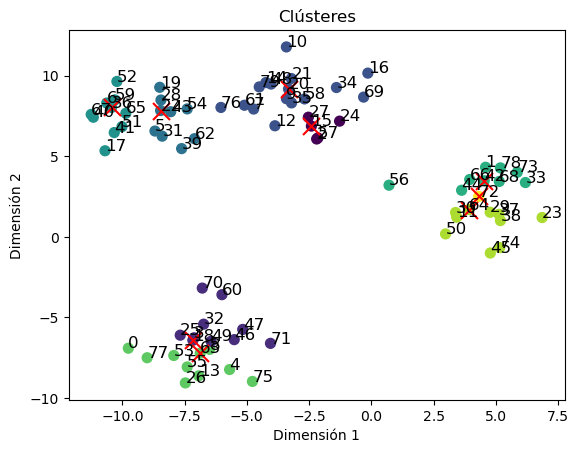




Comenzando proceso de corrección de restricciones.
Restricciones must-links: [[ 7 48  2  2]
 [42 50  5  7]
 [44 66  5  5]
 [28 39  3  3]
 [ 2 35  0  2]
 [21 24  2  0]
 [ 4 46  6  1]
 [50 64  7  7]
 [ 2 14  0  2]
 [37 74  7  7]
 [ 2 27  0  0]
 [69 79  2  2]
 [53 55  6  6]
 [36 40  4  4]
 [54 62  3  3]
 [25 49  1  1]
 [ 5 19  3  3]
 [42 73  5  5]
 [ 2  9  0  2]
 [14 35  2  2]
 [38 72  7  8]
 [ 6 28  4  3]
 [13 63  6  6]
 [40 54  4  3]
 [16 69  2  2]
 [ 3 77  1  6]
 [18 25  1  1]
 [10 79  2  2]
 [35 79  2  2]
 [ 3 75  1  6]
 [51 62  4  3]
 [53 70  6  1]
 [ 5 17  3  4]
 [ 1 78  5  5]
 [24 69  0  2]
 [53 60  6  1]
 [15 58  0  2]
 [ 8 55  6  6]
 [ 8 32  6  1]
 [47 63  1  6]
 [43 59  3  4]
 [28 43  3  3]
 [12 79  2  2]
 [22 41  3  4]
 [29 64  7  7]
 [ 9 48  2  2]
 [ 3 49  1  1]
 [24 79  0  2]
 [42 68  5  5]
 [ 9 27  2  0]
 [52 62  4  3]
 [32 53  1  6]
 [12 69  2  2]
 [29 42  7  5]
 [ 9 10  2  2]
 [31 62  3  3]
 [11 38  7  7]
 [ 4 18  6  1]
 [ 0 46  6  1]
 [55 60  6  1]
 [ 1 66  5  5]
 [50 

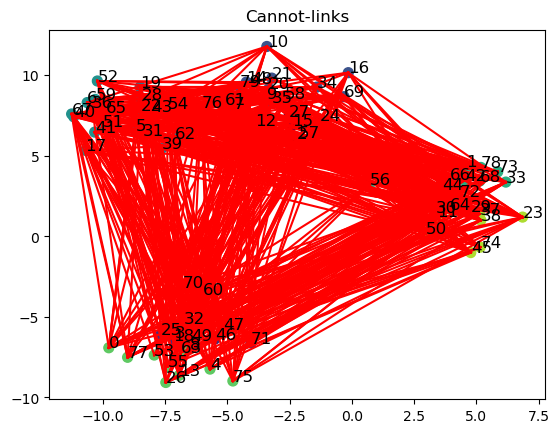

Iteración actual: 0


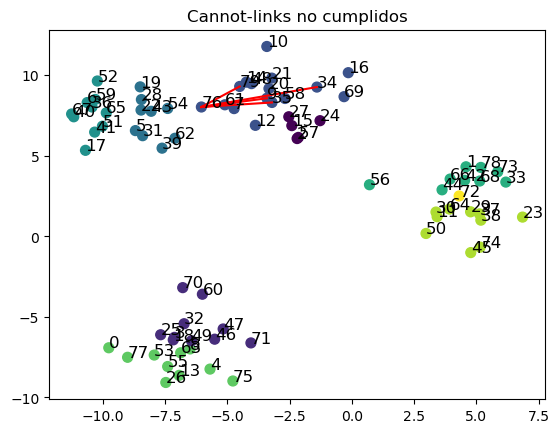

Filas con errores de tipo CL
[ 57  82 233 291 406]
Analizando el problema método 2, varios gammas no nulos
Añadimos el punto 7 (segundo mayor valor) al cluster 9
Clúster actualizados tras añadir el punto
[6 5 0 1 6 3 4 9 6 2 2 7 2 6 2 0 2 4 1 3 2 2 3 7 0 1 6 0 3 7 7 3 1 5 2 2 4
 7 7 3 4 4 5 3 5 7 1 1 2 1 7 4 4 6 3 6 5 0 2 4 1 2 3 6 7 4 5 4 5 2 1 1 8 5
 7 6 2 6 5 2]
Clústeres tras la iteración:
[6 5 0 1 6 3 4 9 6 2 2 7 9 6 2 0 2 4 1 3 2 2 3 7 0 1 6 0 3 7 7 3 1 5 2 2 4
 7 7 3 4 4 5 3 5 7 1 1 2 1 7 4 4 6 3 6 5 0 2 4 1 9 3 6 7 4 5 4 5 2 1 1 8 5
 7 6 9 6 5 2]


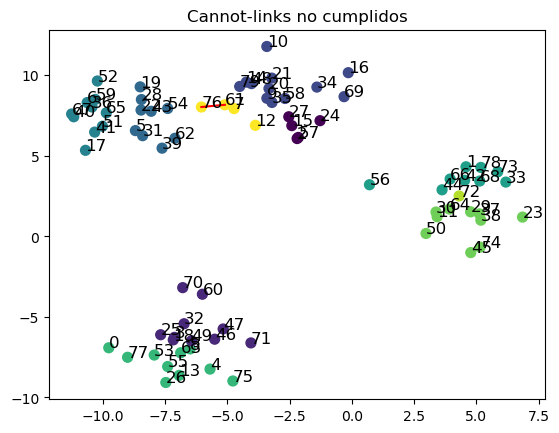

Iteración actual: 1


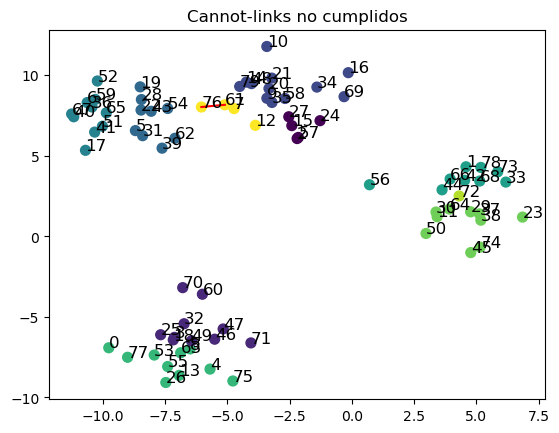

Filas con errores de tipo CL
[82]
Analizando el problema método 2, varios gammas no nulos
Añadimos el punto 12 (segundo mayor valor) al cluster 10
Clúster actualizados tras añadir el punto
[ 6  5  0  1  6  3  4  9  6  2  2  7 10  6  2  0  2  4  1  3  2  2  3  7
  0  1  6  0  3  7  7  3  1  5  2  2  4  7  7  3  4  4  5  3  5  7  1  1
  2  1  7  4  4  6  3  6  5  0  2  4  1  9  3  6  7  4  5  4  5  2  1  1
  8  5  7  6  9  6  5  2]
Clústeres tras la iteración:
[ 6  5  0  1  6  3  4  9  6  2  2  7 10  6  2  0  2  4  1  3  2  2  3  7
  0  1  6  0  3  7  7  3  1  5  2  2  4  7  7  3  4  4  5  3  5  7  1  1
  2  1  7  4  4  6  3  6  5  0  2  4  1  9  3  6  7  4  5  4  5  2  1  1
  8  5  7  6  9  6  5  2]


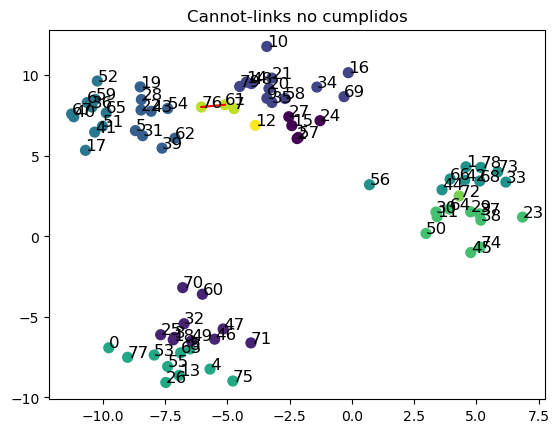

Iteración actual: 2


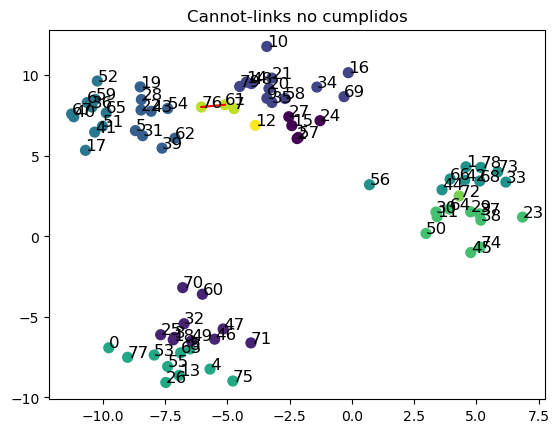

Filas con errores de tipo CL
[82]
Analizando el problema método 2, varios gammas no nulos
Añadimos el punto 76 (segundo mayor valor) al cluster 11
Clúster actualizados tras añadir el punto
[ 6  5  0  1  6  3  4  9  6  2  2  7 10  6  2  0  2  4  1  3  2  2  3  7
  0  1  6  0  3  7  7  3  1  5  2  2  4  7  7  3  4  4  5  3  5  7  1  1
  2  1  7  4  4  6  3  6  5  0  2  4  1  9  3  6  7  4  5  4  5  2  1  1
  8  5  7  6 11  6  5  2]
Clústeres tras la iteración:
[ 6  5  0  1  6  3  4  9  6  2  2  7 10  6  2  0  2  4  1  3  2  2  3  7
  0  1  6  0  3  7  7  3  1  5  2  2  4  7  7  3  4  4  5  3  5  7  1  1
  2  1  7  4  4  6  3  6  5  0  2  4  1  9  3  6  7  4  5  4  5  2  1  1
  8  5  7  6 11  6  5  2]


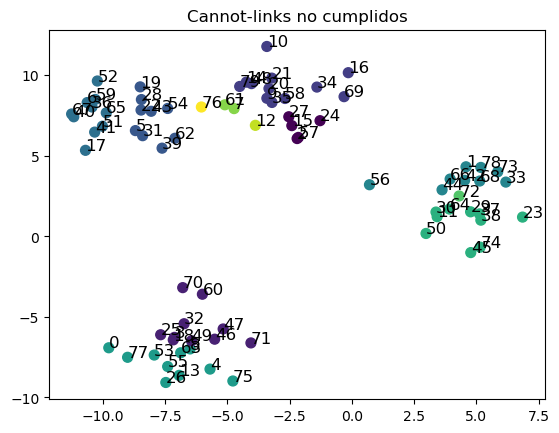

Iteración actual: 3


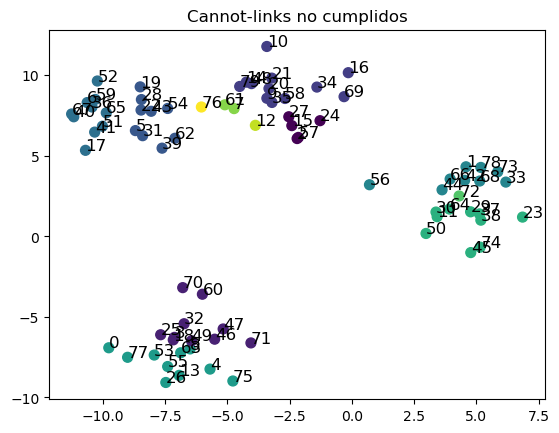

No hay filas con errores de tipo CL



Comenzando proceso de must-links
Restricciones must-links: [[ 7 48  9  2]
 [42 50  5  7]
 [44 66  5  5]
 [28 39  3  3]
 [ 2 35  0  2]
 [21 24  2  0]
 [ 4 46  6  1]
 [50 64  7  7]
 [ 2 14  0  2]
 [37 74  7  7]
 [ 2 27  0  0]
 [69 79  2  2]
 [53 55  6  6]
 [36 40  4  4]
 [54 62  3  3]
 [25 49  1  1]
 [ 5 19  3  3]
 [42 73  5  5]
 [ 2  9  0  2]
 [14 35  2  2]
 [38 72  7  8]
 [ 6 28  4  3]
 [13 63  6  6]
 [40 54  4  3]
 [16 69  2  2]
 [ 3 77  1  6]
 [18 25  1  1]
 [10 79  2  2]
 [35 79  2  2]
 [ 3 75  1  6]
 [51 62  4  3]
 [53 70  6  1]
 [ 5 17  3  4]
 [ 1 78  5  5]
 [24 69  0  2]
 [53 60  6  1]
 [15 58  0  2]
 [ 8 55  6  6]
 [ 8 32  6  1]
 [47 63  1  6]
 [43 59  3  4]
 [28 43  3  3]
 [12 79 10  2]
 [22 41  3  4]
 [29 64  7  7]
 [ 9 48  2  2]
 [ 3 49  1  1]
 [24 79  0  2]
 [42 68  5  5]
 [ 9 27  2  0]
 [52 62  4  3]
 [32 53  1  6]
 [12 69 10  2]
 [29 42  7  5]
 [ 9 10  2  2]
 [31 62  3  3]
 [11 38  7  7]
 [ 4 18  6  1]
 [ 0 46  6  1]
 [55 60  6  1]
 [

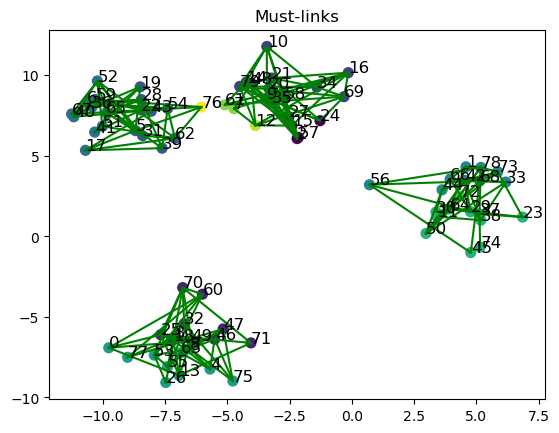

Fusionando clústeres 9 y 2
Centroides de clústeres: [15, 18, 20, 22, 36, 42, 63, 64, 72, 7, 12, 76]
Clústeres tras la fusión:
[ 6  5  0  1  6  3  4  2  6  2  2  7  9  6  2  0  2  4  1  3  2  2  3  7
  0  1  6  0  3  7  7  3  1  5  2  2  4  7  7  3  4  4  5  3  5  7  1  1
  2  1  7  4  4  6  3  6  5  0  2  4  1  2  3  6  7  4  5  4  5  2  1  1
  8  5  7  6 10  6  5  2]


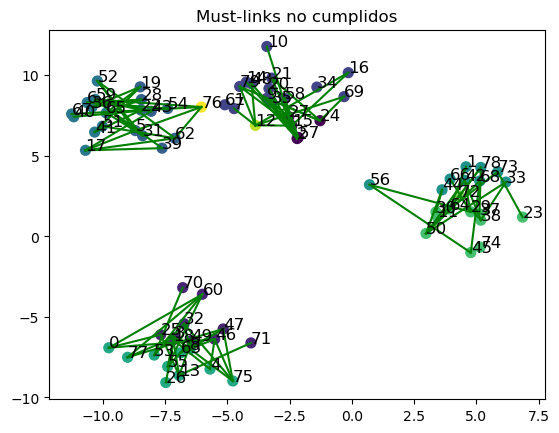

Fusionando clústeres 5 y 7
Centroides de clústeres: [15, 18, 20, 22, 36, 42, 63, 64, 72, 12, 76]
Clústeres tras la fusión:
[6 5 0 1 6 3 4 2 6 2 2 5 8 6 2 0 2 4 1 3 2 2 3 5 0 1 6 0 3 5 5 3 1 5 2 2 4
 5 5 3 4 4 5 3 5 5 1 1 2 1 5 4 4 6 3 6 5 0 2 4 1 2 3 6 5 4 5 4 5 2 1 1 7 5
 5 6 9 6 5 2]


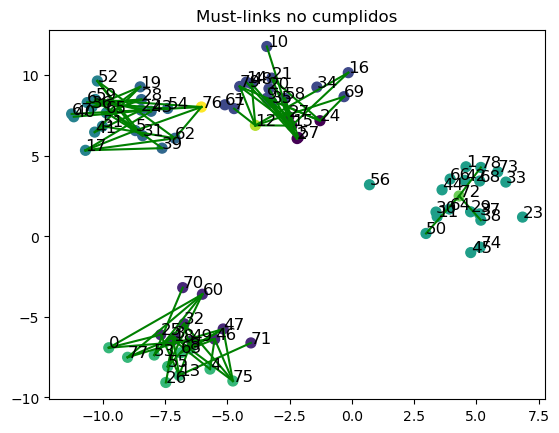

Fusionando clústeres 0 y 2
Centroides de clústeres: [15, 18, 20, 22, 36, 42, 63, 72, 12, 76]
Clústeres tras la fusión:
[5 4 0 1 5 2 3 0 5 0 0 4 7 5 0 0 0 3 1 2 0 0 2 4 0 1 5 0 2 4 4 2 1 4 0 0 3
 4 4 2 3 3 4 2 4 4 1 1 0 1 4 3 3 5 2 5 4 0 0 3 1 0 2 5 4 3 4 3 4 0 1 1 6 4
 4 5 8 5 4 0]


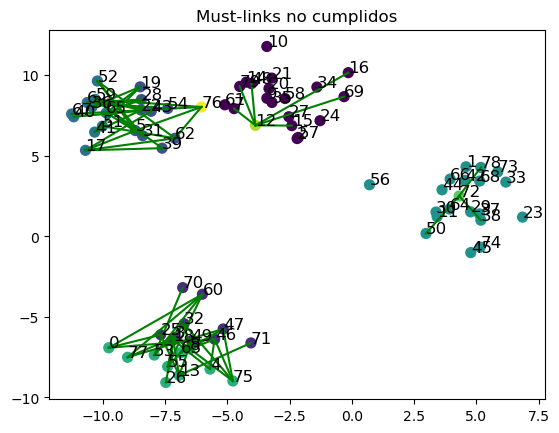

Fusionando clústeres 5 y 1
Centroides de clústeres: [20, 18, 22, 36, 42, 63, 72, 12, 76]
Clústeres tras la fusión:
[1 4 0 1 1 2 3 0 1 0 0 4 6 1 0 0 0 3 1 2 0 0 2 4 0 1 1 0 2 4 4 2 1 4 0 0 3
 4 4 2 3 3 4 2 4 4 1 1 0 1 4 3 3 1 2 1 4 0 0 3 1 0 2 1 4 3 4 3 4 0 1 1 5 4
 4 1 7 1 4 0]


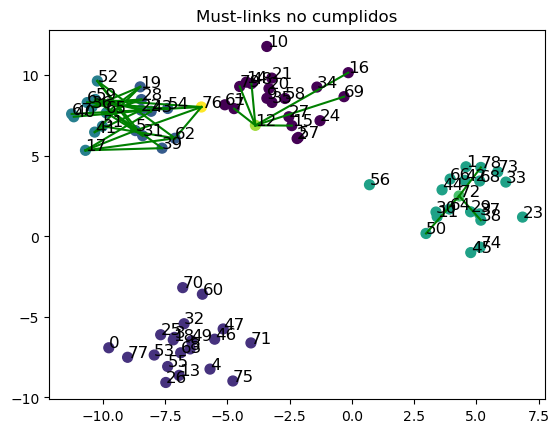

Fusionando clústeres 4 y 5
Centroides de clústeres: [20, 18, 22, 36, 42, 72, 12, 76]
Clústeres tras la fusión:
[1 4 0 1 1 2 3 0 1 0 0 4 5 1 0 0 0 3 1 2 0 0 2 4 0 1 1 0 2 4 4 2 1 4 0 0 3
 4 4 2 3 3 4 2 4 4 1 1 0 1 4 3 3 1 2 1 4 0 0 3 1 0 2 1 4 3 4 3 4 0 1 1 4 4
 4 1 6 1 4 0]


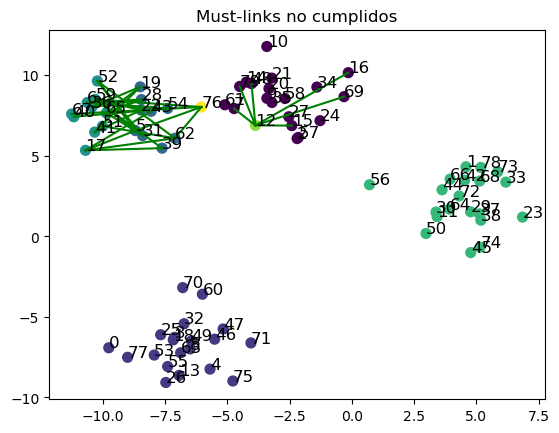

Fusionando clústeres 3 y 2
Centroides de clústeres: [20, 18, 22, 36, 42, 12, 76]
Clústeres tras la fusión:
[1 3 0 1 1 2 2 0 1 0 0 3 4 1 0 0 0 2 1 2 0 0 2 3 0 1 1 0 2 3 3 2 1 3 0 0 2
 3 3 2 2 2 3 2 3 3 1 1 0 1 3 2 2 1 2 1 3 0 0 2 1 0 2 1 3 2 3 2 3 0 1 1 3 3
 3 1 5 1 3 0]


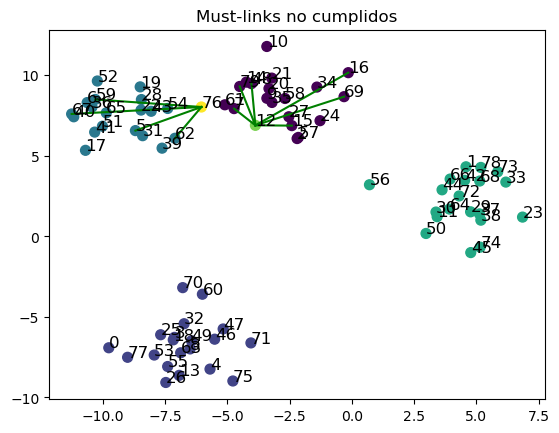

Fusionando clústeres 4 y 0
Centroides de clústeres: [20, 18, 36, 42, 12, 76]
Clústeres tras la fusión:
[1 3 0 1 1 2 2 0 1 0 0 3 0 1 0 0 0 2 1 2 0 0 2 3 0 1 1 0 2 3 3 2 1 3 0 0 2
 3 3 2 2 2 3 2 3 3 1 1 0 1 3 2 2 1 2 1 3 0 0 2 1 0 2 1 3 2 3 2 3 0 1 1 3 3
 3 1 4 1 3 0]


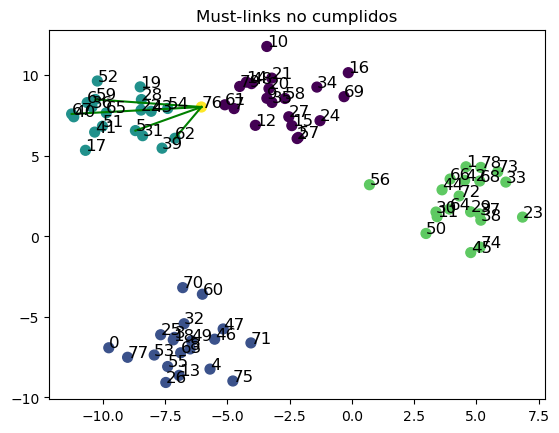

Fusionando clústeres 2 y 4
Centroides de clústeres: [20, 18, 36, 42, 76]
Clústeres tras la fusión:
[1 3 0 1 1 2 2 0 1 0 0 3 0 1 0 0 0 2 1 2 0 0 2 3 0 1 1 0 2 3 3 2 1 3 0 0 2
 3 3 2 2 2 3 2 3 3 1 1 0 1 3 2 2 1 2 1 3 0 0 2 1 0 2 1 3 2 3 2 3 0 1 1 3 3
 3 1 2 1 3 0]


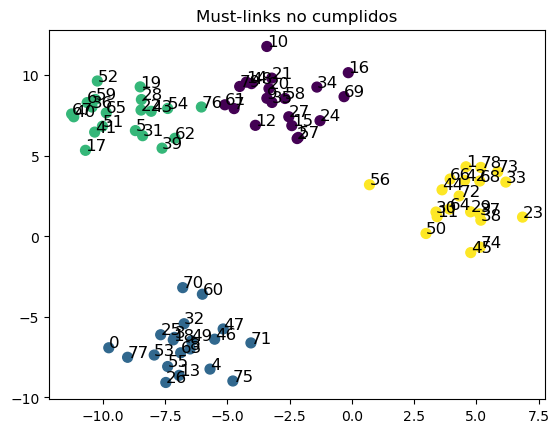

Halos: [ 1  3  0  1  1  2  2  0  1  0 -1  3 -1  1  0  0 -1 -1  1 -1  0  0  2  3
 -1  1  1  0  2  3  3  2  1  3 -1  0  2  3  3 -1  2  2  3  2  3  3  1  1
  0  1  3  2 -1  1  2  1  3  0  0  2  1  0 -1  1  3  2  3  2  3 -1  1  1
  3  3  3  1 -1  1  3  0]



Comenzando proceso de fusión de clústeres
Clústeres: [1 3 0 1 1 2 2 0 1 0 0 3 0 1 0 0 0 2 1 2 0 0 2 3 0 1 1 0 2 3 3 2 1 3 0 0 2
 3 3 2 2 2 3 2 3 3 1 1 0 1 3 2 2 1 2 1 3 0 0 2 1 0 2 1 3 2 3 2 3 0 1 1 3 3
 3 1 2 1 3 0]
Centroides de clústeres: [20, 18, 36, 42]
Halo: [ 1  3  0  1  1  2  2  0  1  0 -1  3 -1  1  0  0 -1 -1  1 -1  0  0  2  3
 -1  1  1  0  2  3  3  2  1  3 -1  0  2  3  3 -1  2  2  3  2  3  3  1  1
  0  1  3  2 -1  1  2  1  3  0  0  2  1  0 -1  1  3  2  3  2  3 -1  1  1
  3  3  3  1 -1  1  3  0]



Iteración actual: 0
Distancias entre clústeres:
[[21.25860729 10.33669403  2.66629549  4.0835714 ]
 [11.79986548 21.25860729 11.90891447 10.07626653]
 [ 2.30799447  9.57349615 21.25860729  9.38632858]
 [ 4.09799168  9.55326559 11.47

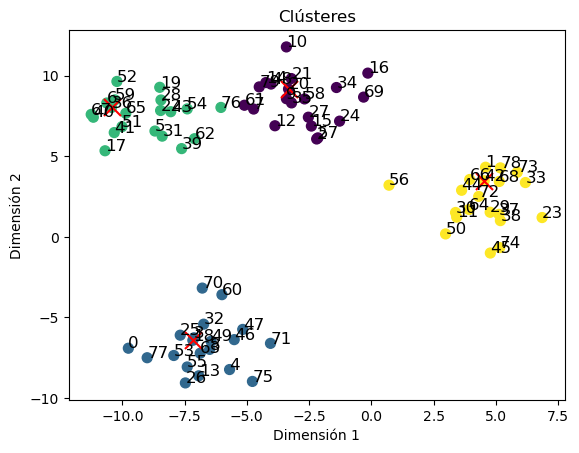

No hay fusiones posibles


In [7]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=80, centers=4, random_state=42, cluster_std=1.5)
CL, ML = MakeCons(y, 10, seed = 20)

cluster = SSDC(D=1, percent=0.03, metric="euclidean", kernel="gaussian", verbose=3)
cluster.fit(X, ml = ML, cl = CL)
labels = cluster.labels_


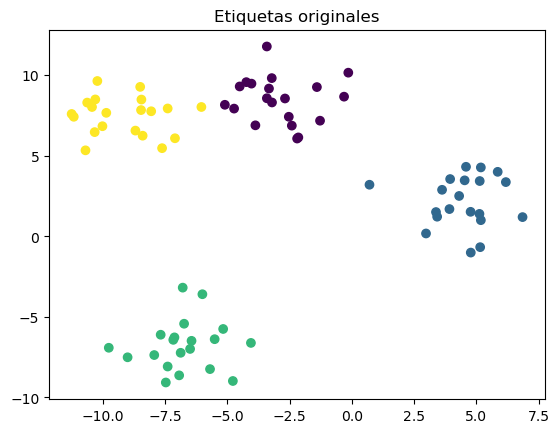

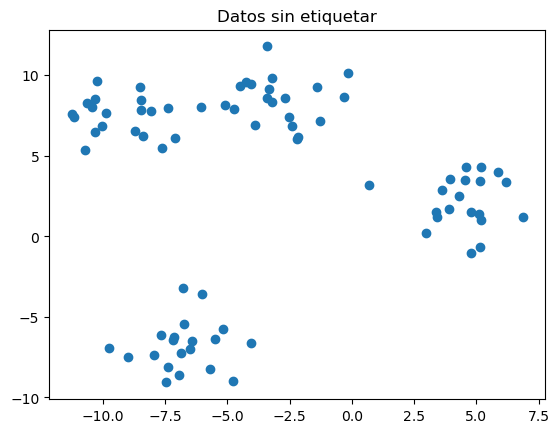

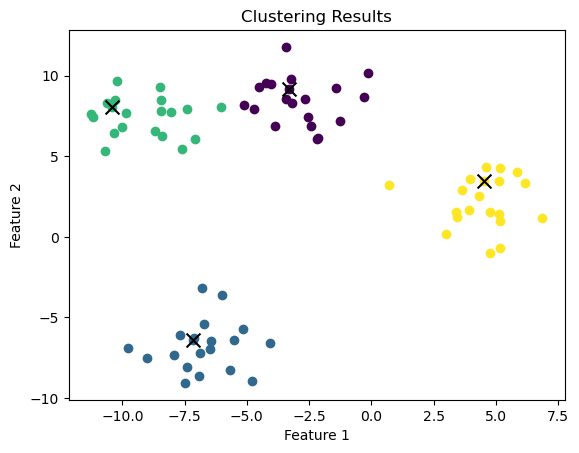

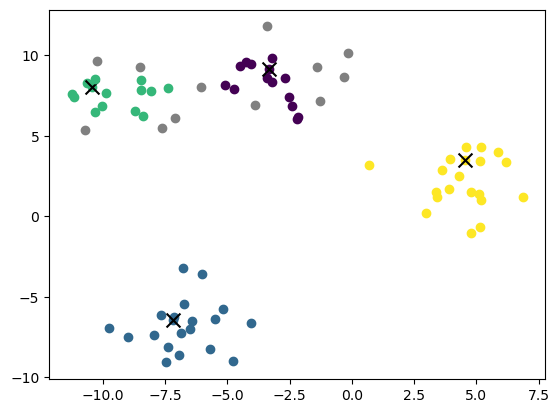

In [8]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0], X[:,1], c = y)
plt.title("Etiquetas originales")
plt.show()

plt.scatter(X[:,0], X[:,1])
plt.title("Datos sin etiquetar")
plt.show()

# Obtener las etiquetas de clase
labels = cluster.labels_

# Obtener los índices de los centroides
centroid_indices = cluster.cluster_cid

# Crear una lista de colores para cada clase
# Obtener la cantidad de etiquetas
num_labels = len(set(labels))

# Generar una paleta de colores con la cantidad de etiquetas
colors = plt.cm.viridis(np.linspace(0, 1, num_labels))
# Crear el gráfico de dispersión con etiquetas y centroides marcados
for i in range(len(X)):
  plt.scatter(X[i, 0], X[i, 1], color=colors[labels[i]])
  
for centroid_index in centroid_indices:
  centroid = X[centroid_index]
  plt.scatter(centroid[0], centroid[1], color='black', marker='x', s=100)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Clustering Results')
plt.show()

halo = cluster.halo
for i in range(len(X)):
  if halo[i]==-1:
    plt.scatter(X[i,0], X[i,1], color='gray')
  else:
    plt.scatter(X[i,0], X[i,1], color=colors[labels[i]])
  if i in centroid_indices:
    plt.scatter(X[i,0], X[i,1], color='black', marker='x', s=100)
  

In [29]:
def halo_func(NCLUST, ND, dist, cl, rho, dc, icl=None):
  halo = cl.copy()
  
  if NCLUST > 0:
    bord_rho = np.zeros(NCLUST+1) # Sumamos 1 pq contamos desde 0
    for i in range(ND-1):
      for j in range(i+1,ND):
        # Si dos elementos son de distinto clúster, pero están cerca
        if cl[i] != cl[j] and dist[i,j]<=dc:
          rho_aver = (rho[i]+rho[j])/2
          print("Comparados puntos ",i,j)
          print("Distancia puntos", dist[i,j])
          print("Distancia máxima", dc)
          print("Densidades y media", rho[i], rho[j], rho_aver)
          print("Densidad borde cluster", cl[i], bord_rho[cl[i]])

          # Si dicha densidad es mayor que la calculada anteriormente
          if rho_aver > bord_rho[cl[i]]:
            # Cambiamos el valor de rho en el borde del cluster del elemento i a rho_aver
            bord_rho[cl[i]] = rho_aver
            print("Se cambia para", cl[i])
          if rho_aver > bord_rho[cl[j]]:
            print("Se cambia para", cl[j])
            bord_rho[cl[j]] = rho_aver
          print("\n")
    for i in range(ND):
      # Si la densidad de un punto es menor que la densidad del borde
      print("Punto")
      print(i)
      print("Rho punto")
      print(rho[i])
      print("Cluster")
      print(cl[i])
      print("Borde rho")
      print(bord_rho[cl[i]])
      if rho[i]<bord_rho[cl[i]]:
        print("Se cumple condición")
        print("\n")
        halo[i] = -1 # Marcamos el punto como punto de halo
    for i in range(NCLUST+1):
      nc = 0
      nh = 0
      for j in range(ND):
        if cl[j] == i:
          nc +=1
        if halo[j]==i:
          nh +=1

    print(bord_rho)
    return halo

In [30]:
halo_func(cluster.NCLUST, cluster.ND, cluster.dist, cluster.cluster, cluster.rho, cluster.minradius, icl = None)

Comparados puntos  2 31
Distancia puntos 6.2053478191226255
Distancia máxima 6.328627260339501
Densidades y media 25.656772313066774 25.390403840458713 25.523588076762742
Densidad borde cluster 0 0.0
Se cambia para 0
Se cambia para 3


Comparados puntos  2 39
Distancia puntos 5.4549774290916275
Distancia máxima 6.328627260339501
Densidades y media 25.656772313066774 24.958079528924696 25.307425920995733
Densidad borde cluster 0 25.523588076762742


Comparados puntos  2 43
Distancia puntos 6.099530526318041
Distancia máxima 6.328627260339501
Densidades y media 25.656772313066774 27.14434907404715 26.40056069355696
Densidad borde cluster 0 25.523588076762742
Se cambia para 0
Se cambia para 3


Comparados puntos  2 54
Distancia puntos 5.522831262254064
Distancia máxima 6.328627260339501
Densidades y media 25.656772313066774 28.01886187375437 26.83781709341057
Densidad borde cluster 0 26.40056069355696
Se cambia para 0
Se cambia para 3


Comparados puntos  2 56
Distancia puntos 4.083571399

array([ 2, -1, -1,  2,  2, -1, -1, -1,  2, -1, -1, -1, -1,  2, -1, -1, -1,
       -1,  2, -1, -1, -1, -1, -1, -1,  2,  2, -1, -1, -1, -1, -1,  2, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  2,  2, -1,  2, -1,
       -1, -1,  2, -1,  2, -1, -1, -1, -1,  2, -1, -1,  2, -1, -1, -1, -1,
       -1, -1,  2,  2, -1, -1, -1,  2,  3,  2, -1, -1])